# PRJ-002: Diabetes 130-US Hospitals for Years 1999-2008 

This project was made for our machine learning course. The goal is to create several models to predict wether a patient will be readmitted before 30 days based on the features of the dataset. The instructions can be found in the 'prj instructions.pdf' file.
 
The models used in the project are Logistic Regression, Random Forest, and K-means Clustering.

## Imports

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

## Import dataset and print basic info

In [27]:
data = pd.read_csv("diabetic_data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

Changing the readmitted to only be 'NO' or '<30'. Because we only want to predict if the patient will be readmitted before 30 days or not.

In [28]:
data['readmitted'] = data['readmitted'].replace({'>30': 'NO'})

## Evaluate data

Below are plots for some of the features that are in the dataset. Below them is a short analysis of why we used or removed the features. 

Function to create plots

In [29]:

def bar_chart_percentage( column_name):
    """
    Plots the distribution of a categorical column grouped by the 'readmitted' column as percentages of the total,
    with percentage annotations on the bars.
    
    Parameters:
    dataframe (pd.DataFrame): The input DataFrame.
    column_name (str): The categorical column for which the percentage distribution will be shown.
    
    Returns:
    None: Displays the percentage bar plot.
    """
    
    # Calculate percentage counts
    percentage_df = (
        
        data.groupby([column_name, 'readmitted'])
        .size()
        .groupby(level=0)
        .apply(lambda x: 100 * x / x.sum())
        .reset_index(name='percentage')
    )

    
    # Create a bar plot with percentages
    plt.figure(figsize=(12, 7))
    barplot = sns.barplot(
        data=percentage_df, 
        x=column_name, 
        y='percentage', 
        hue='readmitted', 
        palette='viridis'
    )

    rotate_annotations = len(data[column_name].unique()) > 7
    
    # Annotate each bar with the percentage value
    for p in barplot.patches:
        barplot.annotate(
            f"{p.get_height():.3f}%",
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5),
            textcoords='offset points',
            rotation= 90 if rotate_annotations else 0
        )
    

    # Customize the plot
    plt.title(f"Percentage Distribution of {column_name} by Readmitted Status")
    plt.xlabel(column_name)
    plt.ylabel("Percentage (%)")
    plt.legend(title='Readmitted', loc='upper right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.show()




#### Gender

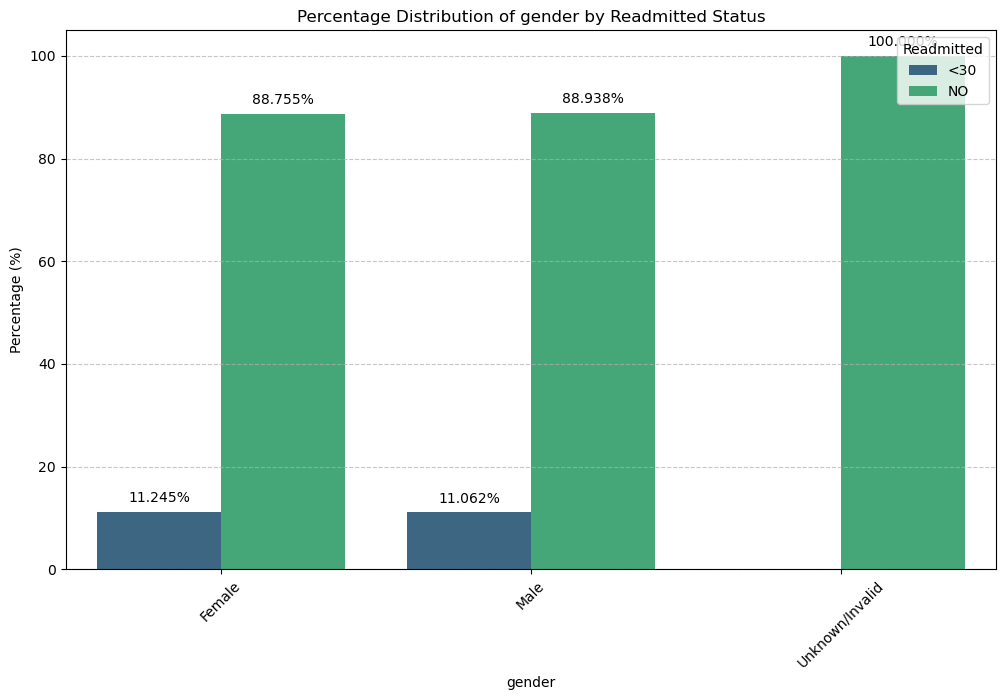

In [30]:
bar_chart_percentage('gender')

In [31]:
data['gender'].value_counts()

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

The 'Unknown/Invalid' category will be removed later, as it only accounts for three rows. Notably, the Female category exhibits a 0.2% higher readmission risk than Male. While this difference could be considered significant in context, it is important to account for the disparity in the number of rows between the two groups. Specifically, there are 7,653 more rows for Female than for Male. This discrepancy suggests that the higher readmission rate for Female could be influenced by the larger sample size rather than an inherent difference in risk. Therefore this feature will be removed because its contribution is minimal.

### Race

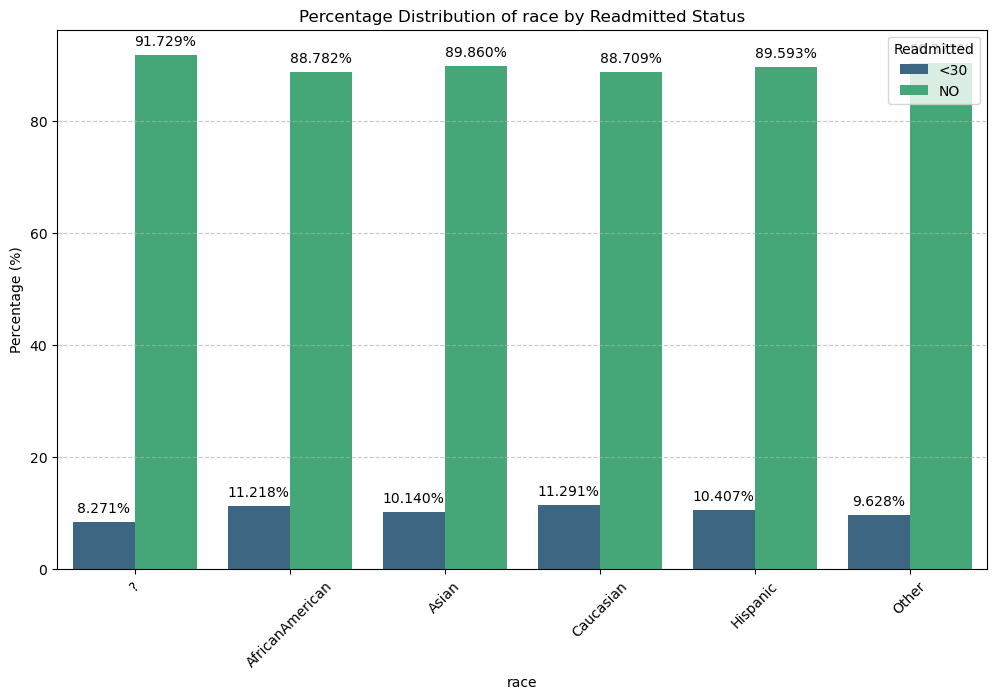

In [32]:
bar_chart_percentage('race')

The '?' category will be moved to 'Other' in the preprocessing stage. 'Caucasian' and 'African American' have a higher chance to be readmitted while 'Asian' and 'Hispanic' have 1% lower, and 'Other' being the lowest.

We can see that

### Discharge Disposition

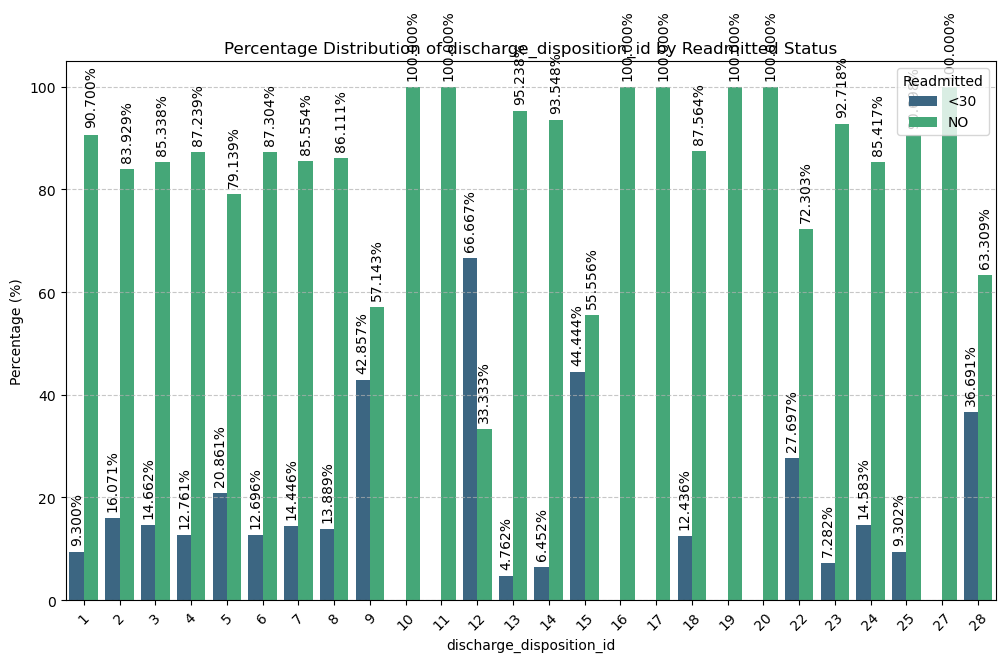

In [33]:
bar_chart_percentage('discharge_disposition_id')

The discharge disposition ID is mapped to numerical values, with corresponding descriptions found in the 'IDS_mapping.csv' file.
  
The percentage varies significantly between the categories, with some dispositions indicating that patients are not going to be readmitted. This feature has a strong impact whether a patient will be readmitted or not.

### Glipizide

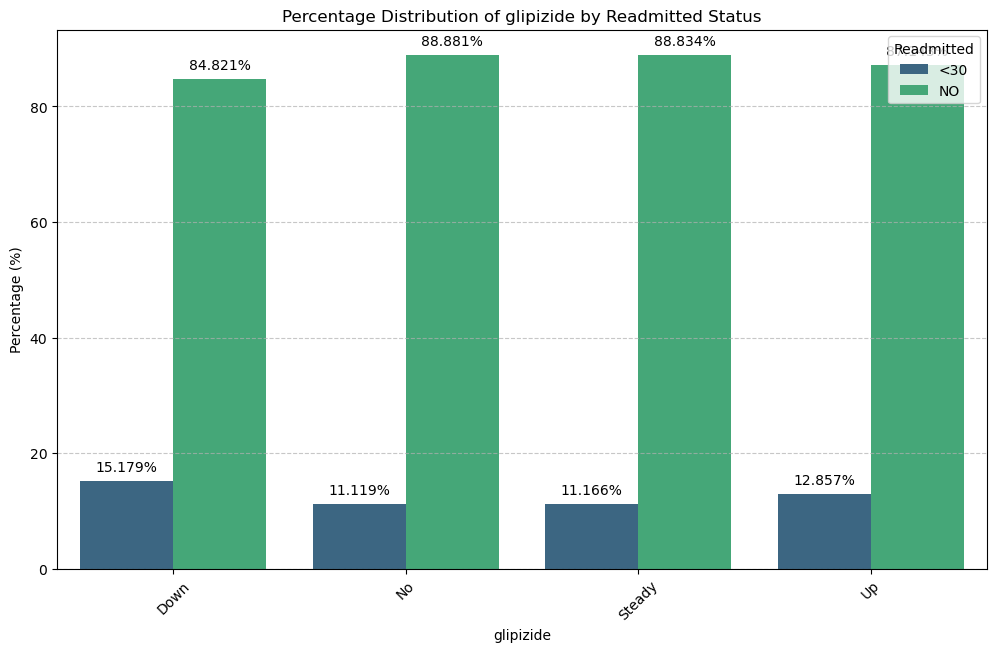

In [34]:
bar_chart_percentage('glipizide')

'Down' has the highest percentage of being readmitted, which could mean that patients that are reducing the dosage needs more monitoring. The same conclusion can be drawn with the 'Up' category but with a lower percentage. 'No' or 'Steady' have a similar percentage with 'Steady' being slightly higher. 

### Diabetes Medication

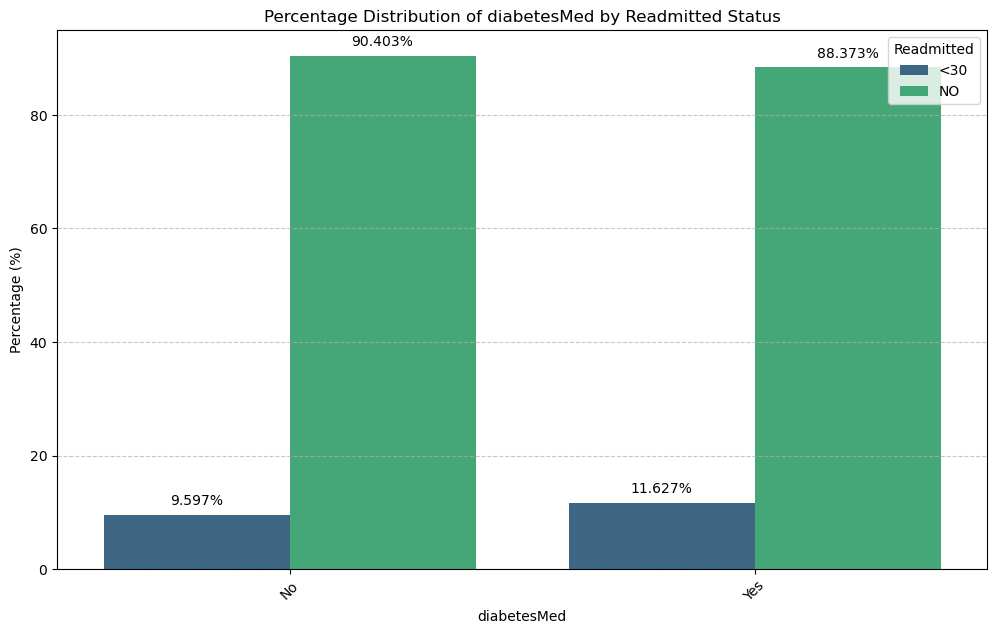

In [35]:
bar_chart_percentage('diabetesMed')

Patients on diabetes medication are 2% more likely to be readmitted than patients who are not on diabetes medication.

### Percentage of '?'

Below is a plot showing how many percent of the features are ?

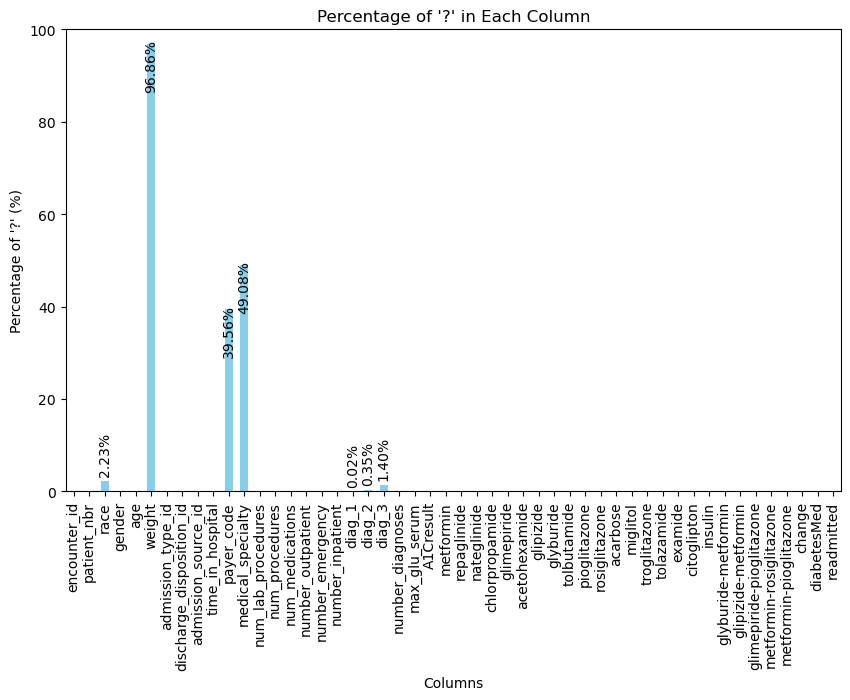

In [36]:
total_counts = data.shape[0]

# Calculate the number of ? values in each column
question_mark_counts = data.apply(lambda col: col.astype(str).str.count(r'\?').sum())

question_mark_percentage = (question_mark_counts / total_counts) * 100

plt.figure(figsize=(10, 6))
question_mark_percentage.plot(kind='bar', color='skyblue')
plt.title("Percentage of '?' in Each Column")
plt.xlabel("Columns")
plt.ylabel("Percentage of '?' (%)")
plt.ylim(0, 100)  # Set y-axis from 0 to 100% for clarity
plt.xticks(rotation=90)

# Add percentage labels on top of each bar
for idx, value in enumerate(question_mark_percentage):
    if(value>0):
        plt.text(idx, value + 1, f'{value:.2f}%', ha='center', va=('top' if value>10 else 'bottom'), fontsize=10, rotation=90)

plt.show()

The weight category is missing 97 % of its values and will be removed in the preprocessing stage.

### Percentage of 'No'

Some of features contain many values that are the same e.g. most of the drug features.
Below is a plot to show how many percentage of the values are 'no'

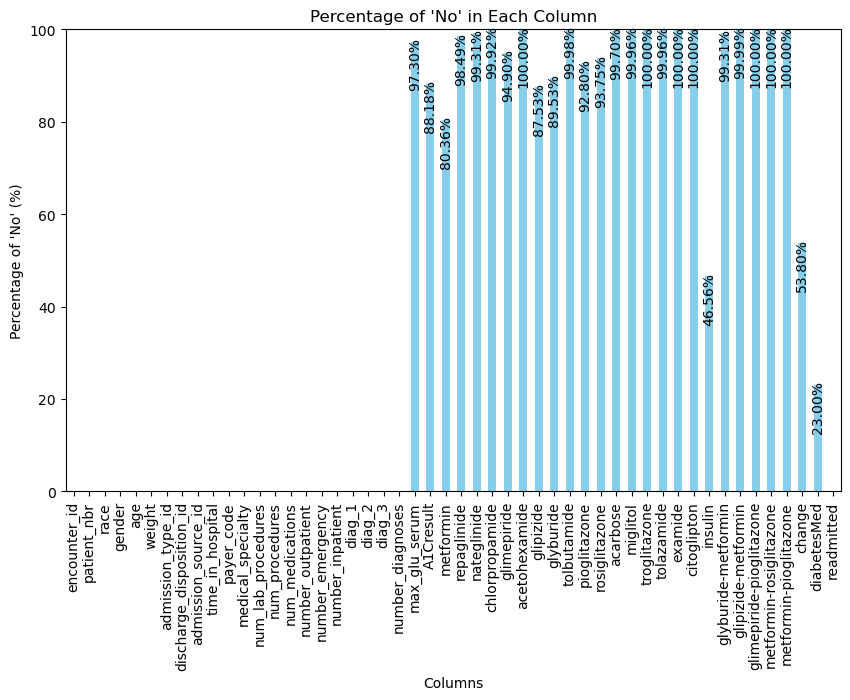

In [37]:
# Calculate the number of NaN values in each column
no_counts = data.apply(lambda col: col.astype(str).str.count('No').sum())

no_percentage = (no_counts / total_counts) * 100

plt.figure(figsize=(10, 6))
no_percentage.plot(kind='bar', color='skyblue')
plt.title("Percentage of 'No' in Each Column")
plt.xlabel("Columns")
plt.ylabel("Percentage of 'No' (%)")
plt.ylim(0, 100)  # Set y-axis from 0 to 100% for clarity
plt.xticks(rotation=90)

# Add percentage labels on top of each bar
for idx, value in enumerate(no_percentage):
    if(value>1):
        plt.text(idx, value + 1, f'{value:.2f}%', ha='center', va=('top' if value>10 else 'bottom'), fontsize=10, rotation=90)


plt.show()

All categories that contain more than 95% of the same value will be removed as these have a minimal contribution to the model. 

## Preprocess Data

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

All rows seem to have no null values but it is incorrect. The null values are defined with a question mark. 

### Dropping columns
Some of the features are redundant and the explanation for removal of each is below.



Feature that are not useful:

|Feature|Explanation|
|---|---|
|gender|Minimal contribution|
|payer_code| Irrelevant to if a patient is readadmitted or not|
|encounter_id| Is unique|
|patient_nbr|Is unique|
|weight|Over 95 % missing values|
|A1Cresult|Made the model worse by 1%|
|max_glu_serum|Over 95 % does not take this drug|
|repaglinide|Over 95 % does not take this drug|
|nateglinide|Over 95 % does not take this drug|
|chlorpropamide|Over 95 % does not take this drug|
|acetohexamide|Same values for all rows|
|tolbutamide|Over 95 % does not take this drug|
|acarbose|Over 95 % does not take this drug|
|miglitol|Over 95 % does not take this drug|
|troglitazone|Same values for all rows|
|tolazamide|Over 95 % does not take this drug|
|examide|Same values for all rows|
|citoglipton|Same values for all rows|
|glyburide-metformin|Over 95 % does not take this drug|
|glipizide-metformin|Over 95 % does not take this drug|
|glimepiride-pioglitazone|Same values for all rows|
|metformin-rosiglitazone|Same values for all rows|
|metformin-pioglitazone|Same values for all rows|


In [39]:
columns_to_drop=['weight','patient_nbr', 'payer_code','encounter_id','max_glu_serum',
                 'repaglinide','nateglinide','chlorpropamide',
                 'acetohexamide','tolbutamide','acarbose','miglitol',
                 'troglitazone','tolazamide','examide', 'citoglipton',
                 'glyburide-metformin','glipizide-metformin',
                 'glimepiride-pioglitazone','metformin-rosiglitazone',
                 'metformin-pioglitazone','A1Cresult','gender']

data.drop(columns=columns_to_drop,  inplace=True)

### Handle missing values

Replace the values that are NAN and only contains ? with "Unknown" and remove missing values in gender to get the same values for all the data. This makes it easier to access and modify.


In [40]:

data.replace('?', np.nan, inplace=True)


data['medical_specialty'].fillna('Unknown', inplace=True)
data['race'].fillna('Other', inplace=True)
data['diag_1'].fillna('Unknown', inplace=True)
data['diag_2'].fillna('Unknown', inplace=True)
data['diag_3'].fillna('Unknown', inplace=True)


# Display updated summary of missing values
print(data.isnull().sum())

race                        0
age                         0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
medical_specialty           0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
metformin                   0
glimepiride                 0
glipizide                   0
glyburide                   0
pioglitazone                0
rosiglitazone               0
insulin                     0
change                      0
diabetesMed                 0
readmitted                  0
dtype: int64


### Encoding

Encode Binary columns

In [41]:
data['change'] = data['change'].map({'Ch': 1, 'No': 0}).astype('int64')
data['diabetesMed'] = data['diabetesMed'].map({'Yes': 1, 'No': 0}).astype('int64')
data['readmitted'] = data['readmitted'].map({'<30':1 , 'NO':0}).astype('int64')


Encode all medicine

In [42]:
medication_columns = ['metformin','glimepiride','glipizide', 'glyburide','pioglitazone','rosiglitazone', 'insulin']

# Numeric mapping for medication columns
data[medication_columns] = data[medication_columns].replace({'Steady': 1, 'No': 0, 'Down': -1, 'Up': 2})


Encode the categorical columns

In [43]:
categorical_colums=['race','medical_specialty','admission_type_id', 'discharge_disposition_id']

# One-Hot Encoding for categorical columns
data = pd.get_dummies(data, columns=categorical_colums, drop_first=True)


Encode Ordinal columns

In [44]:
age_order = [['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']]


ordinal_encoder = OrdinalEncoder(categories=age_order )
data[['age']] = ordinal_encoder.fit_transform(data[['age']])


Encode the diagnoses

The diagnoses are encoded with ICD-9. https://en.wikipedia.org/wiki/List_of_ICD-9_codes
This means we can categorize them into 20 categories to simplify the data. E and V being divided into 2 categories instead of one, and U to -1 for being unknown.

In [45]:
def map_diag(value):
    if isinstance(value,str) and (value.startswith('E') or value.startswith('V') or value.startswith('U')):
        if value.startswith('E'):
            return 17
        elif value.startswith('V'):
            return 18
        elif value.startswith('U'): #When its Unknown
            return -1
    else:
        value=float(value)
        if value <= 139:
            return 0
        elif 140 <= value <= 239:
            return 1
        elif 240 <= value <= 279:
            return 2
        elif 280 <= value <= 289:
            return 3
        elif 290 <= value <= 319:
            return 4
        elif 320 <= value <= 389:
            return 5
        elif 390 <= value <= 459:
            return 6
        elif 460 <= value <= 519:
            return 7
        elif 520 <= value <= 579:
            return 8
        elif 580 <= value <= 629:
            return 9
        elif 630 <= value <= 679:
            return 10
        elif 680 <= value <= 709:
            return 11
        elif 710 <= value <= 739:
            return 12
        elif 740 <= value <= 759:
            return 13
        elif 760 <= value <= 779:
            return 14
        elif 780 <= value <= 799:
            return 15
        elif 800 <= value <= 999:
            return 16

data['diag_1']= data['diag_1'].apply(map_diag) 
data['diag_2']= data['diag_2'].apply(map_diag) 
data['diag_3']= data['diag_3'].apply(map_diag) 



In [46]:
#Check if it worked
data['diag_3'].unique()

array([-1,  2, 18,  6,  0,  7, 16,  1,  9, 12, 15,  8, 11,  4, 13, 17,  5,
       10,  3], dtype=int64)

### Splitting

In [47]:
# Split into features and target
X = data.drop('readmitted', axis=1)
y = data['readmitted']

# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Scaling

In [48]:
scaler = StandardScaler()
numerical_features = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient']

X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

In [49]:
# Testing for missing values, troubleshooting
print("Missing values in X_train:", X_train.isnull().sum().sum())

Missing values in X_train: 0


## Model choice
We decided to start with two classification and one clustering algorithm.
### Logistic Regression
- Effective for rougly linear relationships
- Interpretable (giving us an idea of the meaning of each feature)
- Efficient for large datasets
### Random Forest
- Captures complex, non-linear relationships (good counterpart to Logisitc Regression)
- Allows determining feature importance
- Usually performs well without hypertuning
### K-Means Clustering
- Easy to interpret
- Effective for grouping patients with similar characteristics
- Might still be fast enough for a dataset of our size
- There are different ways to make K-Means faster, if needed.

## Model implementation

### Functions

In [50]:

def plot_feature_importances(model, top_n=None):
    """
    Plots the feature importances of a model.

    Parameters:
    - model: A trained model with a `feature_importances_` attribute (e.g., tree-based models).
    - X_train: Training data as a DataFrame (to automatically retrieve feature names).
    - top_n: Integer specifying the number of top features to plot. If None, all features are plotted.

    """
    # Retrieve feature importances from the model
    importances = model.feature_importances_
    
    # Determine feature names from X_train if provided, otherwise use generic names
    
    feature_names = X_train.columns
    
    
    # Combine feature names and their importance scores
    feature_importance_pairs = list(zip(feature_names, importances))
    
    # Sort features by importance
    feature_importance_pairs = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)
    
    # If specified, select only the top_n features
    if top_n is not None:
        feature_importance_pairs = feature_importance_pairs[:top_n]
    
    # Separate the feature names and their scores after sorting
    features, importance_scores = zip(*feature_importance_pairs)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.barh(features, importance_scores, color="skyblue")
    plt.xlabel("Feature Importance")
    plt.ylabel("Features")
    plt.title("Feature Importances")
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
    plt.show()


### Logistic Regression

In [ ]:
# Initialize
log_reg = LogisticRegression(max_iter=10000, random_state=42)

# Further refinement:
param_grid = {
    'penalty': ['l2'],  # l1 requires more care, especially with 'liblinear' or 'saga'
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear', 'saga'],
}


# Set up GridSearchCV
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1,error_score='raise')

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)  # Ensure you have defined X_train and y_train beforehand

# Display the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation Score:", grid_search.best_score_)

# Evaluate on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)  # Ensure X_test and y_test are defined
print("Test Set Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
# # train
# log_reg.fit(X_train, y_train)

# # Predict
# y_pred_log_reg = log_reg.predict(X_test)

# # Evaluate
# print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log_reg))
# print(classification_report(y_test, y_pred_log_reg))
print(confusion_matrix(y_test, y_pred))

Best Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Best Cross-validation Score: 0.8885790803573537
Test Set Accuracy: 0.8873931413972683
Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     18069
           1       0.45      0.01      0.03      2285

    accuracy                           0.89     20354
   macro avg       0.67      0.51      0.48     20354
weighted avg       0.84      0.89      0.84     20354



#### Analysis

1= Readmitted before 30 days
The model achieved an overall accuracy of 88.7% which seems impressive at first glance. However, upon closer inspection of the performance matrix, it is clear that the model struggles significantly to predict whether a patient will be readmitted or not.

The dataset contains a disproportionate number of samples for the two classes. With 'Readmitted' only having 2285 samples while the rest has 18069. The imbalance causes to model to favour the majority class, leading to a high accuracy but performs poorly to predict readmitted patients.

Notably, there are 3 classes from the start; '<30','>30', and 'No'. When the model trained on all three classes the model performed even worse, thats why we opted for the 2 class dataset.

For class 1 the precision is 0.45, the model incorrectly predicts many of the non-readmitted patients as readmitted. The recall is 0.01 which means the model captures almost none of the actual readmitted patients. This indicates that the model is nearly ineffective at identifying patients who are readmitted, which is the primary goal.

* Macro Average F1-score: 0.48 - Reflects poor balance across both classes
* Weighted Average F1-Score: 0.84 - Skewed by the dominant performance in classifying non-readmitted patients.

#### Conclusion

The poor performance, even after tuning the parameters, suggests that the data is unsatisfactory for a model to train on. The data may lack critical variables that correlate with early readmissions. The imbalance in classes is big flaw in the dataset which makes it harder for the model to generalize the readmitted patients. 

### Improvements

* Enhance the dataset: Collect more features
* Handle Class imbalance: 
    * Resampling: Oversample the minority class or undersample the majority class.
    * Class weighting: Modify the Model to assign higher weight to the minority class.

### Random forest

In [ ]:
# Assuming you have a DataFrame X for features and y for labels
rfc = RandomForestClassifier(random_state=42,n_estimators=50,max_depth=5)

rfc.fit(X_train,y_train)

rfc_pred=rfc.predict(X_test)


# # Step 4: Specify the parameter grid (hyperparameters to tune)
# param_grid = {
#     'n_estimators': [50, 100],  # Number of trees
#     'max_depth': [None, 5, 8, 10],  # Depth of trees
#     'criterion' :['gini', 'entropy'],
#     'max_features': ['auto', 'sqrt', 'log2']
# }

# # Step 5: Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)

# # Step 6: Fit the model
# grid_search.fit(X_train, y_train)

# # Step 7: Retrieve the best parameters and score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# # Print the best parameters and score
# print("Best parameters found: ", best_params)
# print("Best cross-validation score: ", best_score)

# # Step 8: Evaluate on the test set
# test_score = grid_search.score(X_test, y_test)
# print("Test set score: ", test_score)

# Evaluate
print("Logistic Regression Accuracy:", accuracy_score(y_test, rfc_pred))
print(classification_report(y_test, rfc_pred))
print(confusion_matrix(y_test, rfc_pred))

Logistic Regression Accuracy: 0.8873440110052078
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18069
           1       0.45      0.01      0.03      2285

    accuracy                           0.89     20354
   macro avg       0.67      0.51      0.48     20354
weighted avg       0.84      0.89      0.84     20354

[[18028    41]
 [ 2252    33]]


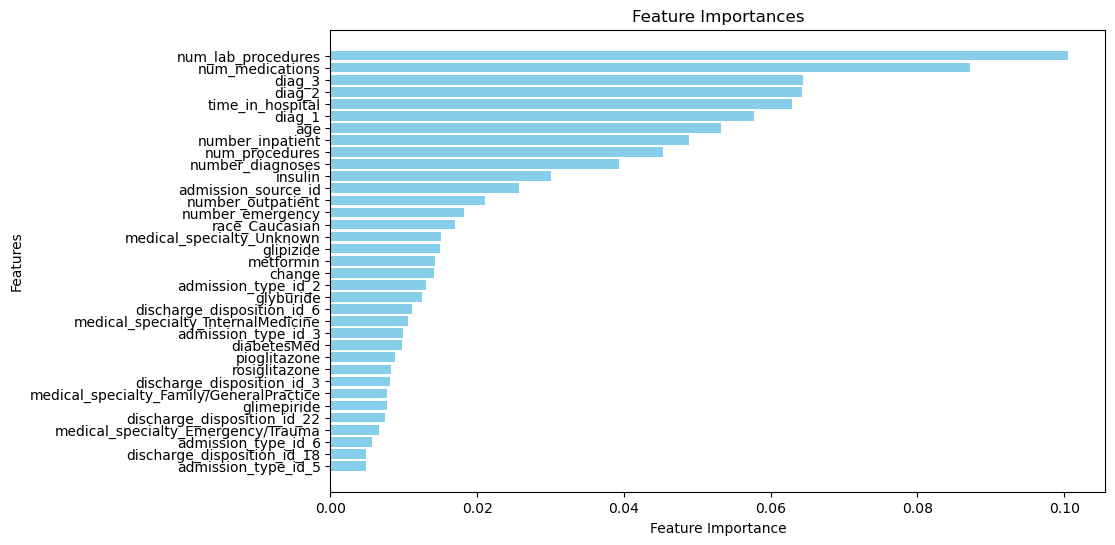

In [ ]:
plot_feature_importances(rfc,35)

In [ ]:

# Evaluate

print("Random Forest Accuracy:", accuracy_score(y_test,rfc_y_pred))
print(classification_report(y_test, rfc_y_pred))
print(confusion_matrix(y_test, rfc_y_pred))

Random Forest Accuracy: 0.8881300972781763
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18069
           1       0.61      0.01      0.02      2285

    accuracy                           0.89     20354
   macro avg       0.75      0.50      0.48     20354
weighted avg       0.86      0.89      0.84     20354

[[18055    14]
 [ 2263    22]]


### K-Means Clustering


In [ ]:
# Creating a separate set of features for K-Means
X_Kmeans = data[['num_lab_procedures', 'num_medications', 'time_in_hospital']]
X_train_Kmeans, X_test_Kmeans, y_train, y_test = train_test_split(X_Kmeans, y, test_size=0.2, random_state=42)
numerical_features_Kmeans = ['num_lab_procedures', 'num_medications', 'time_in_hospital']
X_train_Kmeans[numerical_features_Kmeans] = scaler.fit_transform(X_train_Kmeans[numerical_features_Kmeans])
X_test_Kmeans[numerical_features_Kmeans] = scaler.transform(X_test_Kmeans[numerical_features_Kmeans])

In [ ]:
# Determine optimal number of clusters using the elbow method on X_train
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_Kmeans)  # Use the training features matrix
    sse.append(kmeans.inertia_)

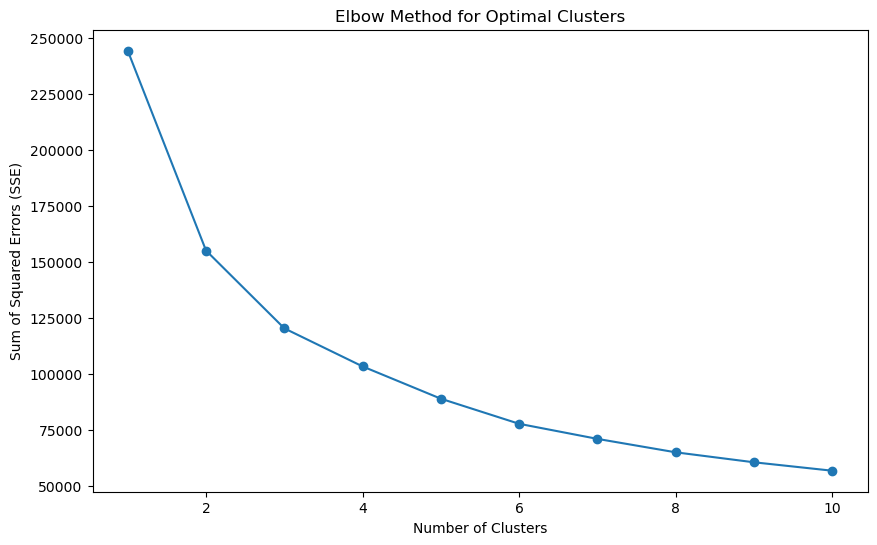

In [ ]:
# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.show()

In [ ]:
# Training K-Means with the optimal number of clusters
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_train_Kmeans)

In [ ]:
# Add cluster labels to X_train for further analysis
X_train_clustered = X_train_Kmeans.copy()
X_train_clustered['Cluster'] = clusters

In [ ]:
# Evaluate clustering performance using silhouette score
silhouette_avg = silhouette_score(X_train_Kmeans, clusters)
print(f"Silhouette Score for {optimal_k} clusters: {silhouette_avg:.4f}")

Silhouette Score for 4 clusters: 0.2531


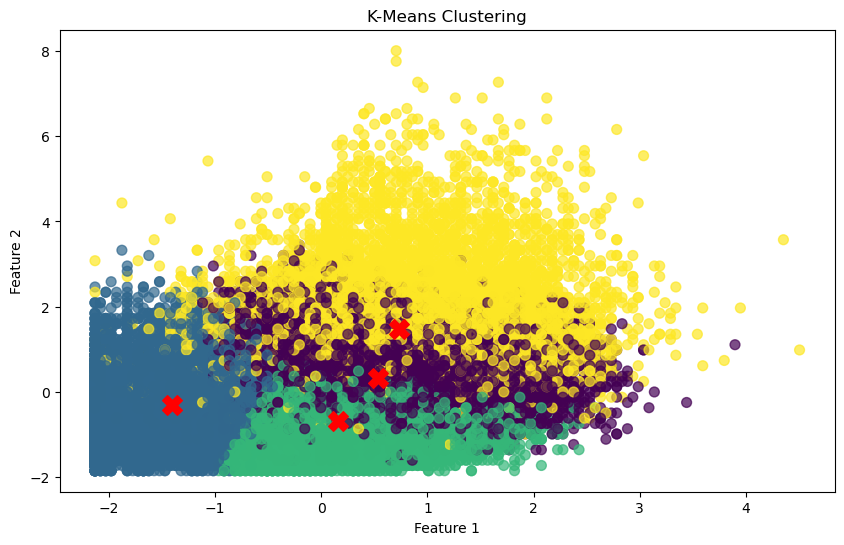

In [ ]:
# Visualize the clusters if feasible (only if X_train has 2 or 3 dimensions)
if X_train_Kmeans.shape[1] <= 3:
    plt.figure(figsize=(10, 6))
    plt.scatter(X_train_Kmeans.iloc[:, 0], X_train_Kmeans.iloc[:, 1], c=clusters, cmap='viridis', s=50, alpha=0.7)
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color='red', marker='X', s=200)
    plt.title("K-Means Clustering")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()